In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import mlfinlab as ml
from tqdm import tqdm_notebook

Step 1. Generate volume bars (on average 1M contacts is traded in ES futures) => threshold = 0.02 * 1e6 (2% of daily volume)

In [8]:
# takes approximately 1h 30min
volume_bars_dict = {}
for f in tqdm_notebook(os.listdir('es_data/')):
    volume_bars_dict[f] = ml.data_structures.get_volume_bars('es_data/{}'.format(f), threshold=1e6*0.02, verbose=False, to_csv=False)

In [14]:
del volume_bars_dict['ESU18.csv'] # no volume bars for this contract
del volume_bars_dict['ESZ18.csv'] # no volume bars for this contract
del volume_bars_dict['ESM18.csv'] # too few volume bars for this contract

It turns out that it is really difficult to find historical ES rollover dates, let's define them by the date of the last bar generated

In [15]:
expiration_dates = {}
for ticker, df in volume_bars_dict.items():
    volume_bars_dict[ticker]['date_time'] = pd.to_datetime(volume_bars_dict[ticker]['date_time']) # convert strings to date_times
    expiration_dates[ticker] = volume_bars_dict[ticker].date_time.dt.date.max()

generate aggregated data frame with all volume bars

In [16]:
aggregated_df = pd.DataFrame()
for ticker, df in volume_bars_dict.items():
    df['ticker'] = ticker
    aggregated_df = aggregated_df.append(df)

In [17]:
aggregated_df.sort_values(by='date_time', inplace=True) # sort by timestamp

now we need to generate the column which stores the nearest contract ticker

In [46]:
nearest_contract_df = pd.DataFrame()
nearest_contract_df['nearest_contract'] = expiration_dates.keys() # tickers
nearest_contract_df['date'] = expiration_dates.values() # expiration dates

In [47]:
aggregated_df['date'] = aggregated_df.date_time.dt.date
aggregated_df['nearest_contract'] = np.nan

In [57]:
nearest_contract_df.sort_values(by='date', inplace=True)

In [74]:
# generate column with the first contract
aggregated_df['nearest_contract'] = np.nan
aggregated_df.sort_values(by='date_time', inplace=True)
aggregated_df.reset_index(drop=True, inplace=True)
counter = 0
nearest_contract = nearest_contract_df.iloc[counter].nearest_contract
nearest_expiration = nearest_contract_df.iloc[counter].date
for index, row in aggregated_df.iterrows():
    if row['date'] < nearest_expiration: 
        aggregated_df.loc[index, 'nearest_contract'] = nearest_contract
    else:
        # expiration date -> take the next contract
        counter += 1
        try:
            nearest_contract = nearest_contract_df.iloc[counter].nearest_contract
            nearest_expiration = nearest_contract_df.iloc[counter].date
        except IndexError:
            print('end')
        aggregated_df.loc[index, 'nearest_contract'] = nearest_contract
    

end
end
end
end
end
end
end
end
end
end
end
end
end
end
end
end
end
end
end
end
end
end
end
end
end
end
end
end
end
end
end
end
end
end
end
end
end
end
end
end
end
end
end
end
end
end
end
end
end
end
end
end


In [76]:
aggregated_with_nearest_contract.set_index('date_time', inplace=True) # set date_time index

In [77]:
def get_futures_roll_series(data_df, open_col, close_col, sec_col, current_sec_col, roll_backward=False):
    """
    Function for generating rolling futures series from data frame of multiple futures.
    :param data_df: (pd.DataFrame): pandas DataFrame containing price info, security name and current active futures column
    :param open_col: (string): open prices column name
    :param close_col: (string): close prices column name
    :param sec_col: (string): security name column name
    :param current_sec_col: (string): current active security column name. When value in this column changes it means rolling
    :param roll_backward: (boolean): True for subtracting final gap value from all values
    :return (pd.Series): futures roll close price series
    """
    # Filter out security data which is not used as current security
    filtered_df = data_df[data_df[sec_col] == data_df[current_sec_col]]
    filtered_df.sort_index(inplace=True)

    # Generate roll dates series based on current_sec column value change
    roll_dates = filtered_df[current_sec_col].drop_duplicates(keep='first').index
    gaps = filtered_df[close_col] * 0  # roll gaps series

    # On roll dates, gap equals open - close
    gaps.loc[roll_dates[1:]] = filtered_df[open_col].loc[roll_dates[1:]] - filtered_df[close_col].loc[
        roll_dates[1:]]
    gaps = gaps.cumsum()

    if roll_backward:
        gaps -= gaps.iloc[-1]  # Roll backward

    return gaps

In [78]:
cont_first_contract_gaps = get_futures_roll_series(aggregated_df, open_col='open', close_col='close',
                                                   sec_col='ticker', current_sec_col='nearest_contract')

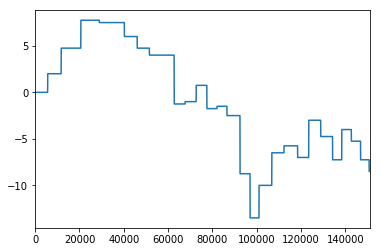

In [79]:
cont_first_contract_gaps.plot()

In [80]:
first_contract = aggregated_df[aggregated_df.ticker == aggregated_df.nearest_contract] # filter out only firth contract

/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

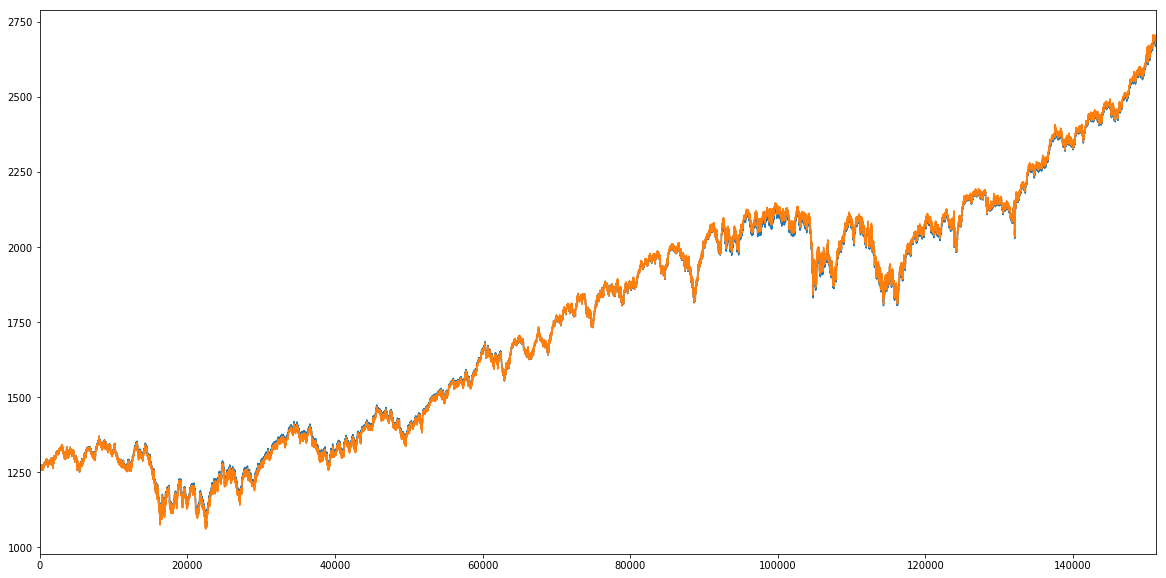

In [82]:
plt.figure(figsize=(20, 10))
first_contract.close.plot()

first_contract['open'] -= cont_first_contract_gaps
first_contract['high'] -= cont_first_contract_gaps
first_contract['low'] -= cont_first_contract_gaps
first_contract['close'] -= cont_first_contract_gaps

first_contract.close.plot()
plt.show()